In [1]:
# Loading the libraries
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
import numpy as np
import pandas as pd

In [2]:
# Loading the training and test dataset
def load_crime_data(file):
    df = pd.read_csv(file, header=None, na_values='?')
    
    # Dropping the non-predictive or non-useful features from selected columns
    df.drop(columns=range(0,5), axis=1, inplace=True)
    
    # Selecting the columns having one or more missing values (NaN)
    cols_with_nan = df.columns[df.isnull().any()]
    
    # Columns with too many NaNs are removed
    df.drop(columns=cols_with_nan[1:], axis=1, inplace=True)
    
    # Filling the one missing value of column 30 by its mean
    df.fillna(df.mean(), inplace=True)
    
    # Seperating the features and target values and putting into X and Y
    X = df.iloc[:, 0:df.shape[1]-1] # All the columns
    Y = df.iloc[:, df.shape[1]-1] # Just the last column
    
    # Separating the training and testing datasets (20%)
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Normalizing the input dataframe using Mean normaliztion
    trainX = (trainX-trainX.mean()) / trainX.std()
    testX = (testX-testX.mean()) / testX.std()
    
    # Returning the relevant data
    return trainX, np.ravel(trainY), testX, np.ravel(testY)


# Defining the sequencial model
def define_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(100,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

def cross_val(trainX, trainY, n_split, n_epochs, batch_):
    all_scores = []
    all_mae_histories = []
    
    # K-Fold cross validation    
    cv = KFold(n_splits=n_split, random_state=42)

    for train, test in cv.split(trainX, trainY):
        partial_train_data, partial_train_targets = trainX.iloc[train, :], trainY[train]
        val_data, val_targets = trainX.iloc[test, :], trainY[test]
        
        # Training using the training fold
        model = define_model()
        history = model.fit(partial_train_data, partial_train_targets, epochs = n_epochs, batch_size = batch_, verbose=0)
        
        # Recording the training performance
        mae_history = history.history['mae']
        all_mae_histories.append(mae_history)
        
        # Recording the validation performance per fold
        val_mse, val_mae = model.evaluate(val_data, val_targets)
        all_scores.append(val_mae)

    #Per epoch average mae score for all folds
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]
    return average_mae_history, all_scores, model

def plotResult(average_mae_history):
    plt.figure(1)
    plt.plot(range(1, len(average_mae_history)+1), average_mae_history)    
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.savefig('Validation_mae.png')
    plt.show()

In [3]:
# Defining the model
def run_model():
    trainX, trainY, testX, testY = load_crime_data('communities.data')
    
    # Running the cross validation
    avg_mae_history, val_fold_scores, model = cross_val(trainX, trainY, n_split=10, n_epochs=1500, batch_=64)
    model.save('crime_model.h5')
    
    # Evaluatng the model
    plotResult(avg_mae_history)
    print('K-fold Validation MAE Scores', val_fold_scores)
    print('Average Validation Score:', np.mean(val_fold_scores))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


5/5 [==============================] - 0s 850us/step - loss: 0.0211 - mae: 0.0987


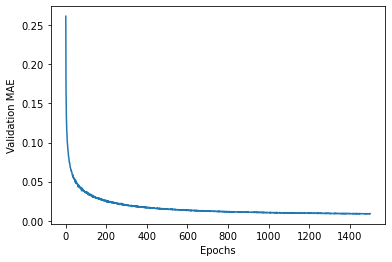

K-fold Validation MAE Scores [0.10363873094320297, 0.09944131225347519, 0.10992560535669327, 0.10207416862249374, 0.12031766027212143, 0.09687363356351852, 0.0949840396642685, 0.10718996822834015, 0.09614656865596771, 0.09865924715995789]
Average Validation Score: 0.10292509347200393


In [4]:
# Running the model
run_model()

In [5]:
# Loading the saved model and evaluating it on the test data
trainX, trainY, testX, testY = load_crime_data('communities.data')
final_model = load_model('crime_model.h5')
_, final_mae  = final_model.evaluate(testX, testY, verbose=0)

print('Mean Absolute Error = %.2f' % (final_mae))

Mean Absolute Error = 0.11
